##### Import required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

%matplotlib inline

<blockquote> Load Your training dataset </blockquote>

In [2]:
train_math = pd.read_csv('student-mat.csv', sep = ';')
train_por = pd.read_csv('student-por.csv', sep = ';')

Observe the train_math and train_por datasets.

In [3]:
train_math.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
train_por.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Add a column of subject in both datasets.

In [5]:
train_math['Sub'] = 'M'
train_por['Sub'] = 'P'

Concatenate the two datasets.

In [6]:
full_data = pd.concat([train_math, train_por], ignore_index = True)

Drop those rows which doesn't have importance in predicting final grades.

In [7]:
full_data.drop(['Mjob', 'Fjob', 'reason'], axis = 1, inplace = True)

There are some values in G3 which is equal to zero and this will affect the final grade prediction.<br>
So, we can fix this by replacing the value with the average of G1 and G2.

In [8]:
# Index of the values where G3 = 0
index = full_data[full_data['G3'] == 0].index

In [9]:
#change G3 = 0 to avg of G1 and G2
full_data.loc[index,'G3'] = (full_data.loc[index,'G1'] + full_data.loc[index,'G2']) / 2

In [10]:
#convert float to int
full_data['G3'] = full_data['G3'].round(0).astype(int)

##### Visualizations

Relation between sex and grades.

<AxesSubplot:xlabel='sex'>

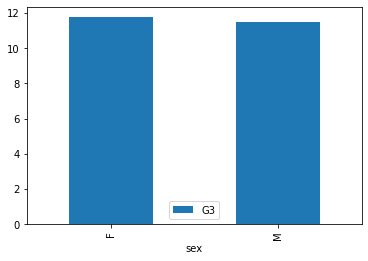

In [11]:
full_data[['sex', 'G3']].groupby('sex').mean().plot(kind = 'bar')

Scatterplot relation with absences and G3.

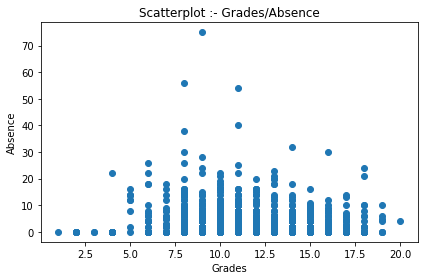

In [12]:
plt.scatter(x = full_data['G3'], y = full_data['absences'])
plt.xlabel('Grades')
plt.ylabel('Absence')
plt.title('Scatterplot :- Grades/Absence')
plt.tight_layout()
plt.show()

Relation between studytime and grades

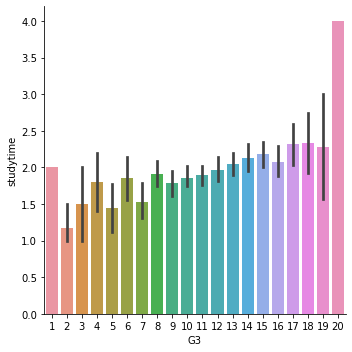

In [13]:
sns.catplot(x = 'G3', y = 'studytime', kind = 'bar', data = full_data)
# A lesson for you : - study more to get good grades..

One of the best and easiest way to find relation between variables is to print the correlation matrix

<AxesSubplot:>

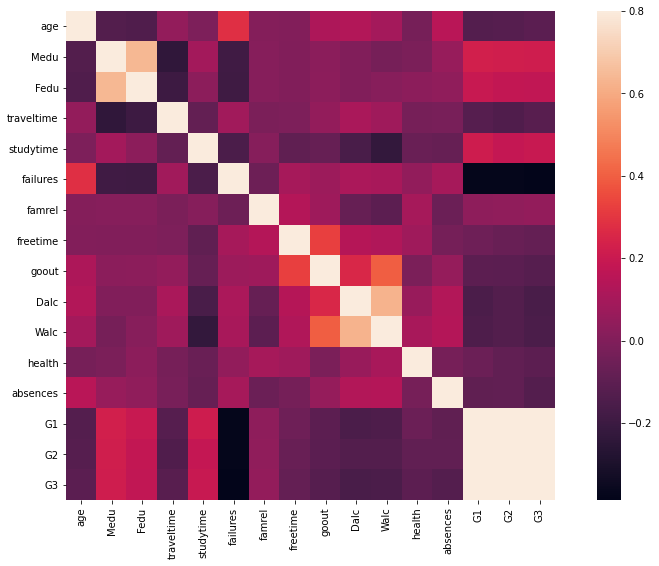

In [14]:
corr_mat = full_data.corr()
f, ax = plt.subplots(figsize = (15,9))
sns.heatmap(corr_mat, vmax = .8, square = True)

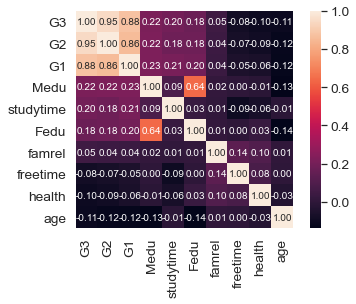

In [15]:
k = 10
cols = corr_mat.nlargest(k, 'G3')['G3'].index
cm = np.corrcoef(full_data[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt  = '.2f',
                annot_kws = {'size':10}, yticklabels = cols.values, xticklabels = cols.values)

Convert the age column from numerical to catgorical .


In [16]:
full_data['age'] = full_data['age'].astype('str')

Separate the numerical columns from full_data

In [17]:
num_data = full_data.select_dtypes(exclude = ['object', 'category']).copy()

In [18]:
num_data.head(5)

,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6
1,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6
2,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10
3,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15
4,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10


Skewness of num_data

In [19]:
print(num_data.skew())

Medu         -0.139528
Fedu          0.119447
traveltime    1.369314
studytime     0.670982
failures      2.783660
famrel       -1.055775
freetime     -0.178707
goout         0.038928
Dalc          2.157973
Walc          0.625923
health       -0.498800
absences      3.741347
G1            0.077922
G2           -0.497357
G3           -0.133685
dtype: float64


Apply log transformations to those columns which have high skewness.

In [20]:
num_data['traveltime'] = np.log1p(num_data['traveltime'])
num_data['failures'] = np.log1p(num_data['failures'])
num_data['famrel'] = np.log1p(num_data['famrel'])
num_data['Dalc'] = np.log1p(num_data['Dalc'])
num_data['Walc'] = np.log1p(num_data['Walc'])
num_data['absences'] = np.log1p(num_data['absences'])

Skewness of columns after applying log transformations.

In [21]:
print(num_data.skew())

Medu         -0.139528
Fedu          0.119447
traveltime    0.926969
studytime     0.670982
failures      2.165059
famrel       -1.928162
freetime     -0.178707
goout         0.038928
Dalc          1.574588
Walc          0.228861
health       -0.498800
absences      0.166194
G1            0.077922
G2           -0.497357
G3           -0.133685
dtype: float64


Normalize num_data

In [22]:
num_data = preprocessing.StandardScaler().fit_transform(num_data)

Update the original data

In [23]:
full_data.update(num_data, errors = 'raise')

Do One Hot Encoding to categorical columns

In [24]:
full_data = pd.get_dummies(full_data)

Remove the target variable

In [25]:
Y = full_data['G3'].copy()
full_data.drop(['G3'], axis = 1, inplace = True)

Split the datasets into training , testing and validation sets.

In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(full_data, Y, test_size = 0.15, random_state = 16)
X_train1, X_test, Y_train1, Y_test = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 16)

Choose best parameters for the model using GridSearchCV.

In [ ]:
#Round 1 of GridSearchCV
param_grid = {
    'gamma' : [0, 0.25, 0.5, 1],
    'learn_rate' : [0.01, 0.03, 0.09, 0.1, 0.6],
    'max_depth' : [3, 4, 5],
    'reg_lambda' : [5, 10, 15],
    'scale_pos_weight' : [3, 4, 5]
}
optimal_params = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'multi:softmax',
                                                           colsample_bytree = 0.5,
                                                           subsample = 0.9),
                             param_grid = param_grid,
                             scoring = 'accuracy',
                             verbose = 2,
                             cv = 3,
                             n_jobs = -1)

I comment the fitting portion of gridsearchcv because it will take a lot of time to train , around 25 mins.

In [ ]:
'''grid_result = optimal_params.fit(X_train, Y_train)
best_params = grid_result.best_params_'''

In [ ]:
#best_params

In [ ]:
# Round2 of gridSearchCV
param_grid2 = {
    'reg_lambda' : [0.1, 0.5, 1, 3, 5],
    'scale_pos_weight' : [1, 2, 3]
}
optimal_params2 = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'multi:softmax',
                                                           colsample_bytree = 0.5,
                                                           subsample = 0.9),
                             param_grid = param_grid2,
                             scoring = 'accuracy',
                             verbose = 2,
                             cv = 3,
                             n_jobs = -1)

In [ ]:
'''grid_result2 = optimal_params2.fit(X_train, Y_train)
best_params2 = grid_result2.best_params_'''

In [ ]:
#best_params2

After getting the best parameters from both rounds of GridSearchCV <br>
we will then define the model using those parameters..<br><br>
We will use XGBClassifier to train the model.

In [27]:
#Model
clf_xgb = xgb.XGBClassifier(seed = 42,
                        objective = 'multi:softmax',
                        gamma = 0.25,
                        learn_rate = 0.01,
                        max_depth = 4,
                        reg_lambda = 0.1,
                        scale_pos_weight = 1,
                        subsample = 0.9,
                        colsample_bytree = 0.5,
                        num_class = 20,    
                        n_estimators = 1000)

Train the model.

In [28]:
history = clf_xgb.fit(X_train1, Y_train1,early_stopping_rounds = 50, 
                      verbose = True, eval_metric = 'merror', eval_set = [(X_val, Y_val)])

[0]	validation_0-merror:0.675159
Will train until validation_0-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.700637
[2]	validation_0-merror:0.598726
[3]	validation_0-merror:0.566879
[4]	validation_0-merror:0.598726
[5]	validation_0-merror:0.585987
[6]	validation_0-merror:0.592357
[7]	validation_0-merror:0.579618
[8]	validation_0-merror:0.579618
[9]	validation_0-merror:0.579618
[10]	validation_0-merror:0.566879
[11]	validation_0-merror:0.566879
[12]	validation_0-merror:0.56051
[13]	validation_0-merror:0.56051
[14]	validation_0-merror:0.56051
[15]	validation_0-merror:0.56051
[16]	validation_0-merror:0.566879
[17]	validation_0-merror:0.592357
[18]	validation_0-merror:0.598726
[19]	validation_0-merror:0.585987
[20]	validation_0-merror:0.573248
[21]	validation_0-merror:0.573248
[22]	validation_0-merror:0.592357
[23]	validation_0-merror:0.598726
[24]	validation_0-merror:0.598726
[25]	validation_0-merror:0.598726
[26]	validation_0-merror:0.592357
[27]	validation_0-merror:0.58

Predict the values for X_test.

In [29]:
Y_hat = clf_xgb.predict(X_test)

In [30]:
Y_hat

array([11, 16, 16, 15, 14, 12,  8, 10, 16, 11, 11, 16,  8, 14,  8, 12,  4,
       15, 11, 13, 11,  8, 13, 10, 12, 10, 13, 10, 10, 12, 18,  8,  8, 12,
       14, 11, 10,  6,  6, 11, 10, 10, 13, 18, 13,  8, 11,  8, 13,  8, 12,
       15, 10, 17, 13, 10, 14,  6, 12, 16, 13, 13, 10,  6,  4, 13, 15, 12,
       10, 15,  8, 11, 13, 17, 10, 11, 14, 13,  8, 10, 10, 18, 14,  8, 13,
        9, 13, 11,  6, 13,  8, 10, 12, 12, 11, 13, 15,  8, 11, 12, 10, 14,
       16,  6,  6, 16, 11, 16, 14,  6,  8, 13, 16, 10,  8, 11, 12, 10,  8,
       10,  8, 10, 14, 13, 13, 13, 14, 12, 11, 15, 13, 13, 10, 13])

In [31]:
np.array(Y_test)

array([ 9, 16, 15, 16, 15, 13,  9, 10, 16, 10, 10, 16,  7, 14,  8, 12,  4,
       16, 12, 13,  9,  8, 14, 10, 12, 10, 14, 10, 10, 12, 18,  8,  6, 12,
       13, 12, 12,  5,  6, 11,  9,  9, 12, 17, 14,  8, 11,  8, 14,  7, 13,
       15, 10, 17, 15,  9, 13,  6, 12, 16, 13, 12, 10,  4,  5, 14, 15, 11,
       10, 17,  5, 11, 13, 17, 10, 11, 13, 13,  8, 10, 11, 19, 13, 10, 13,
       10, 14, 11,  6, 14, 10, 10, 13, 11, 11, 12, 16,  7, 10, 13, 10, 14,
       17,  6,  5, 16, 11, 17, 14,  6,  8, 13, 16, 10, 10, 12, 14, 10,  8,
       10,  5, 10, 15, 14, 13, 13, 14, 11, 11, 15, 13, 13,  9, 14])